# P&D ISSP - Base notebook
@Students: You are free to edit anything you want.

Packages

In [1]:
import os
import matplotlib
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
ROOTPATH = 'F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main'  #  /!/  Adapt this to your system  /!/ 
pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters (examples)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]

Build acoustic scenario and generate RIRs using GUI

In [98]:
# Launch GUI
guifcns.RIRg_GUI(
    exportFolder=f'{os.getcwd()}/rirs',
    outputRIRplot=False,
    distBwMics=10,  # [cm]
    fs=44100,
    t60=0,
    theme='SystemDefault',
)

Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 10 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250304_092404.pkl.gz", in folder
"f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\rirs"
You may close the GUI if not needed anymore!


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(2.0250000000000004), np.float64(3.025)]]
>> Field "audioIds": ['25']
>> Field "c": 340
>> Field "distBwMics": 0.05
>> Field "exportFolder": f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19]
>> Field "micCoords": [[np.float64(4.0), np.float64(2.9749999999999996)], [np.float64(4.0), np.float64(3.025)], [np.float64(4.0), np.float64(3.075)], [np.float64(4.0), np.float64(3.125)], [np.float64(4.0), np.float64(3.175)]]
>> Field "micsIds": ['20', '21', '22', '23', '24']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": [[np.float64(2.0), np.float64(1.025)]]
>> Field "noiseIds": ['26']
>> Field "numMics": 5
>> Field "rirLength": 22050
>> Field "roomDim": 5.0
>> Field "t60": 0.0
>> Field "theme": SystemDefault

RIRs selection

(22050, 5, 1)


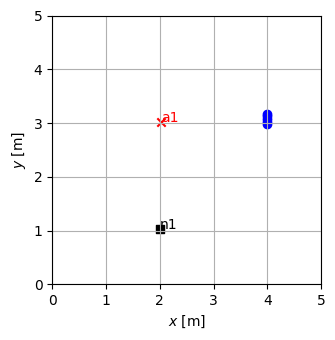

<Figure size 640x480 with 0 Axes>

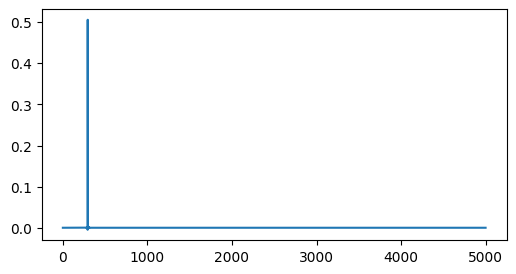

In [99]:
import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,0,0])

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)


(441000, 5)


<Figure size 640x480 with 0 Axes>

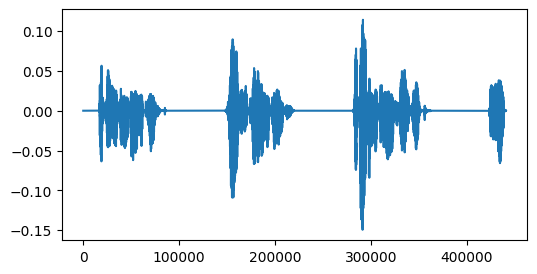

<Figure size 640x480 with 0 Axes>

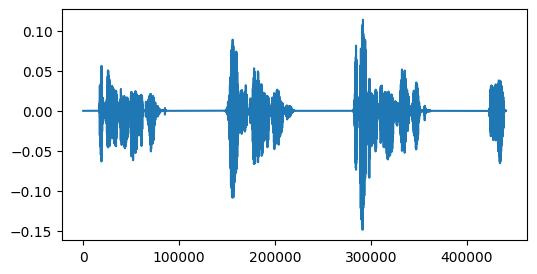

In [70]:
# Part 2
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(audio_name1, audio_name2, noise_name, acousticScenario):
    num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
    num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
    if acousticScenario.RIRsNoise is None:
        num_noise = 0   # number of noise sources
    else:
        num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        RIR_noise1 = acousticScenario.RIRsNoise.squeeze(axis=2)  
      
    fs = acousticScenario.fs    # unit: Hz
    T_ds = int(10*fs)  # unit: s

    if num_audio == 2:
        RIR_audio1, RIR_audio2 = np.dsplit(acousticScenario.RIRsAudio, 2)
        RIR_audio1 = RIR_audio1.squeeze(axis=2)
        RIR_audio2 = RIR_audio2.squeeze(axis=2)
    else:
        RIR_audio1 = acousticScenario.RIRsAudio.squeeze(axis=2)
    
    speech1, sr_speech1 = sf.read(audio_name1)
    speech2, sr_speech2 = sf.read(audio_name2)
    noise1, sr_noise1 = sf.read(noise_name)

    num_samples_speech1 = int(len(speech1) * fs / sr_speech1)
    num_samples_speech2 = int(len(speech2) * fs / sr_speech2)
    num_samples_noise = int(len(noise1) * fs / sr_noise1)
    speech1 = signal.resample(speech1, num_samples_speech1)
    speech2 = signal.resample(speech2, num_samples_speech2)
    noise1 = signal.resample(noise1, num_samples_noise)

    speech1 = speech1[0:T_ds]
    speech2 = speech2[0:T_ds]
    noise1 = noise1[0:T_ds]

    mic1 = []
    mic2 = []

    for i in range(num_micro):
        rec_signal1_tmp = scipy.signal.fftconvolve(speech1, RIR_audio1[:,i])
        if num_audio == 2:
            rec_signal2_tmp = scipy.signal.fftconvolve(speech2, RIR_audio2[:,i])
        else:
            rec_signal2_tmp = np.zeros(rec_signal1_tmp.shape)

        if acousticScenario.RIRsNoise is not None:
            rec_noise_tmp = scipy.signal.fftconvolve(noise1, RIR_noise1[:,i])  
            rec_signal1_tmp = rec_signal1_tmp + rec_noise_tmp

        mic1.append(rec_signal1_tmp)
        mic2.append(rec_signal2_tmp)

    mic1 = np.array(mic1)
    mic2 = np.array(mic2)

    mic = mic1 + mic2    
    mic = mic.T

    return mic[0:T_ds,:], speech1, speech2, noise1, fs

mic, speech1, speech2, noise1, fs = create_micsigs('F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech1.wav', 'F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech2.wav',"F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)

# sd.play(speech1[0:fs*1], fs)
sd.play(mic[:,0], fs)

print(mic.shape)

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,0])

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,1])


(441000, 4)


<Figure size 640x480 with 0 Axes>

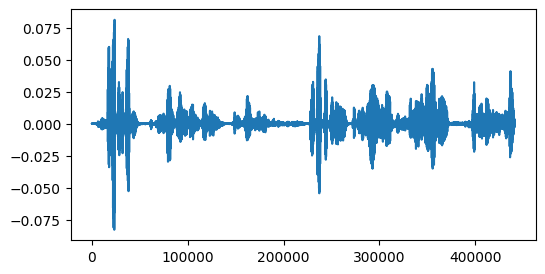

<Figure size 640x480 with 0 Axes>

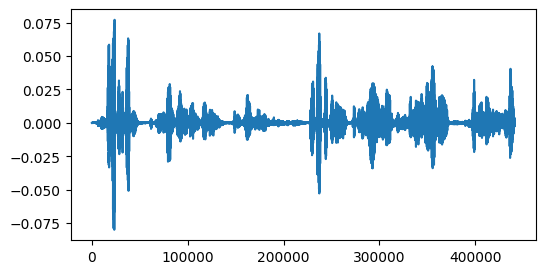

In [3]:
# Part 2 Ruben's version: compatible with arbitrary number of audio sources and noise sources
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s, hmr_paths):
    
    if len(hmr_paths) == 0:
        num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
        # num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
        # num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        fs = acousticScenario.fs
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        
        # Load and resample noise sources
        noise_components = []
        for file in noise_audio_files:
            noise, fs_noise = sf.read(file)
            noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
            noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
            noise_components.append(noise_padded)

        mic_signals = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
            for noise_idx, noise in enumerate(noise_components):
                rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
                mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')

            mic_signals[:, mic_idx] = mic_signal
    else:
        all_paths = []
        for fpath in hmr_paths:
            all_paths.append([fpath + "/HMIR_L1.wav",fpath + "/HMIR_L2.wav",fpath + "/HMIR_R1.wav",fpath + "/HMIR_R2.wav"])
        fs = sf.read(all_paths[0][0])[1]
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        noise_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)

        num_micro = 4
        mic_signals = np.zeros((T_ds, num_micro))

        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = sf.read(all_paths[audio_idx][mic_idx])[0]
                rir_speech = rir_speech[0:int(0.005*fs)]
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
        
            mic_signals[:, mic_idx] = mic_signal
            
    # Plot first two microphone signals
    # for mic_idx in range(num_micro):
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(mic_signals[:, mic_idx], label=f'Mic {mic_idx + 1}')
    #     plt.title(f"Microphone {mic_idx + 1} Signal")
    #     # plt.xlim((6425,6470))
    #     plt.xlabel("Samples")
    #     plt.ylabel("Amplitude")
    #     plt.legend()
    #     plt.show()
    
    return mic_signals, speech_components, noise_components, fs


Time_duration = 10
mic, speech, noise, fs = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track1_dry.wav","F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track2_dry.wav"], [], acousticScenario, Time_duration, ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s-60","F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s60"])
# mic, speech, noise, fs = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track1_dry.wav"], [], acousticScenario, Time_duration, ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s-30"])    # single sudio source on left-hand side
# mic, speech, noise, fs = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track2_dry.wav"], [], acousticScenario, Time_duration, ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30"])    # single sudio source on right-hand side
# mic = mic[:,0:2]    # Select L1&L2
# mic = mic[:,2:4]    # Select R1&R2
# mic = mic[:,[0,2]]    # Select L1&R1

# sd.play(speech1[0:fs*1], fs)
# sd.play(mic[:,2], fs)

print(mic.shape)
# Play the first microphone signal
# sd.play(mic[:, 2], samplerate=acousticScenario.fs)
# sd.wait()  # Wait until playback finishes

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,0])

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,1])

In [ ]:
#Part 3
import numpy as np
import scipy.signal as signal

def TDOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  rir1 = acousticScenario.RIRsAudio[:,0,0]
  rir2 = acousticScenario.RIRsAudio[:,1,0]

  direct_path_idx1 = np.argmax(np.abs(rir1))
  direct_path_idx2 = np.argmax(np.abs(rir2))

  ground_truth_TDOA = (direct_path_idx1 - direct_path_idx2) / acousticScenario.fs
  print(f"Ground truth TDOA: {ground_truth_TDOA:.6f} seconds")

  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:, 0] # Signal of the first mic
  mic2 = mic_signals[:, 1] # Signal of the second mic

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs
  print(f"Estimated TDOA: {estimated_TDOA:.6f} seconds")

  plt.figure(figsize=(8, 4))
  plt.plot(lags / acousticScenario.fs, cross_corr, label="Crosscorrelation")
  plt.stem([ground_truth_TDOA], [np.max(cross_corr)], linefmt="r-", markerfmt="ro", basefmt="r-", label="Groundtruth")
  plt.stem([estimated_TDOA], [np.max(cross_corr)], linefmt="g-", markerfmt="go", basefmt="g-", label="Estimated value")

  plt.xlabel("Time difference (seconden)")
  plt.ylabel("Crosscorrelation amplitude")
  plt.legend()
  plt.title("TDOA estimate via crosscorrelation")
  plt.xlim(-0.01, 0.01)
  plt.grid()
  plt.show()

  # Step 5: Print de fout tussen de schatting en de grondwaarheid
  error = np.abs(estimated_TDOA - ground_truth_TDOA)
  print(f"TDOA estimation error: {error:.6f} seconds")

TDOA_corr('F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav', 'F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav',"F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)



In [ ]:
#Part 4
def DOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:,0] # First mic signal
  mic2 = mic_signals[:,1] # Second mic signal

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  cross_corr /= np.max(np.abs(cross_corr))
  peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

  if len(peaks) < 2:
    raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")
  
  peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
  selected_peaks = peaks[peak_indices]

  TDOAestAll = []

  for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

  print(f"First estimated TDOA: {TDOAestAll[0]:.6f} seconds")
  print(f"Second estimated TDOA: {TDOAestAll[1]:.6f} seconds")

  c = 340 # Speed of sound in air (m/s)
  mic_distance = acousticScenario.distBwMics
  TDOAestAll = np.array(TDOAestAll)
  cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
  cos_theta = np.clip(cos_theta, -1, 1)
  DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

  print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")
  print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
  
  plt.figure(figsize=(8, 4))
  plt.plot(lags / fs, cross_corr, label="cross correlation")
  plt.axvline(x=estimated_TDOA, color='g', linestyle="--", label=f"TDOA: {estimated_TDOA:.6f}s")

  plt.xlabel("Time difference (seconds)")
  plt.ylabel("Cross correlation amplitude")
  plt.legend()
  plt.xlim(-0.01,0.01)
  plt.title("TDOA and DOA estimation via crosscorrelation")
  plt.grid()
  plt.show()
  

  DOAestAll = DOA_estimate
  DOAestAll = np.array(DOAestAll)
  return DOAestAll

DOAestALL = DOA_corr("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)
print(DOAestALL)


In [ ]:
# Part 5
def TDOA_corr_2(audio1_name, audio2_name, noise_name, acousticScenario, mic):
 first_source = 0
 second_source = 1
 rir1_1 = acousticScenario.RIRsAudio[:,first_source,0]
 rir2_1 = acousticScenario.RIRsAudio[:,second_source,0]

 direct_path_idx1_1 = np.argmax(np.abs(rir1_1))
 direct_path_idx2_1 = np.argmax(np.abs(rir2_1))

 ground_truth_TDOA_1 = (direct_path_idx1_1 - direct_path_idx2_1) / acousticScenario.fs

 print(f"Ground truth TDOA of source 1: {ground_truth_TDOA_1:.6f} seconds")

 rir1_2 = acousticScenario.RIRsAudio[:,first_source,1]
 rir2_2 = acousticScenario.RIRsAudio[:,second_source,1]

 direct_path_idx1_2 = np.argmax(np.abs(rir1_2))
 direct_path_idx2_2 = np.argmax(np.abs(rir2_2))

 ground_truth_TDOA_2 = (direct_path_idx1_2 - direct_path_idx2_2) / acousticScenario.fs

 print(f"Ground truth TDOA of source 2: {ground_truth_TDOA_2:.6f} seconds")

 mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

 mic1 = mic_signals[:, 0] # Signal of the first mic
 mic2 = mic_signals[:, 1] # Signal of the second mic

 cross_corr = signal.correlate(mic1, mic2, mode="full")
 lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

 cross_corr /= np.max(np.abs(cross_corr))
 peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

 if len(peaks) < 2:
  raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")

 # Select the two highest peaks
 peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
 selected_peaks = peaks[peak_indices]

 TDOAestAll = []

 for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

 estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

 print(f"First estimated TDOA: {TDOAestAll[1]:.6f} seconds")
 print(f"Second estimated TDOA: {TDOAestAll[0]:.6f} seconds")

 c = 340 # Speed of sound in air (m/s)
 mic_distance = acousticScenario.distBwMics
 TDOAestAll = np.array(TDOAestAll)
 cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
 cos_theta = np.clip(cos_theta, -1, 1)
 DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

 print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
 print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")

TDOA_corr_2("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario, mic)


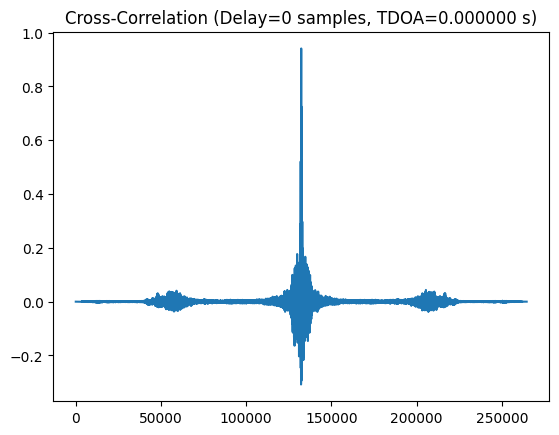

DOA estimate for HMIR_L1.wav & HMIR_L2.wav: 90.00°


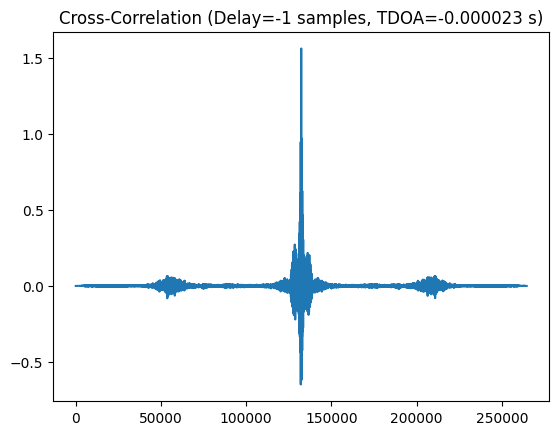

DOA estimate for HMIR_R1.wav & HMIR_R2.wav: 126.37°


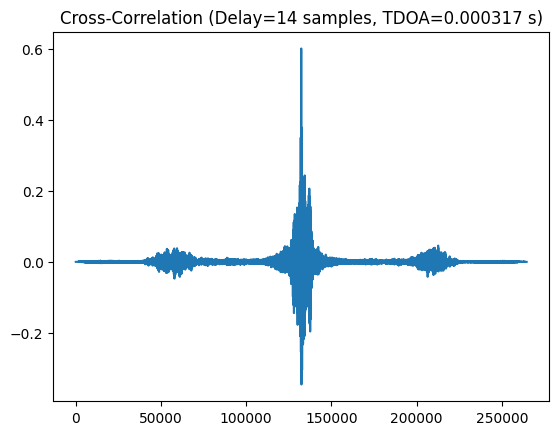

DOA estimate for HMIR_L1.wav & HMIR_R1.wav: 59.87°


In [71]:
# Part 6
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import os
import glob

def create_micsigs_2(rir_files, audio_file):
  # """Generates microphone signals from measured impulse responses."""
  rir_signals = [sf.read(f)[0] for f in rir_files]
  audio, fs_audio = sf.read(audio_file)

  # Ensure sampling rates match
  fs_rir = sf.read(rir_files[0])[1]

  T_ds = int(3*fs_rir)
  audio = audio[0:T_ds]

  if fs_audio != fs_rir:
    audio = sig.resample(audio, int(len(audio) * fs_rir / fs_audio))

  # Convolve with impulse response
  mic_signals = [sig.fftconvolve(audio, rir)[:len(audio)] for rir in rir_signals]

  return np.column_stack(mic_signals), fs_rir

def estimate_tdoa(mic1, mic2, fs):
  """Estimates the time difference of arrival (TDOA) using cross-correlation."""
  # corr = sig.correlate(mic1, mic2, mode='full')
  # delay = sig.correlation_lags(len(mic1),len(mic2), mode='full')
  # tdoa = delay[np.argmax(corr)] / fs
  corr = sig.correlate(mic1, mic2, mode='full')
  delay = np.argmax(corr) - (len(mic1) - 1)
  tdoa = delay / fs

  plt.figure()
  plt.plot(corr)
  plt.title(f"Cross-Correlation (Delay={delay} samples, TDOA={tdoa:.6f} s)")
  plt.show()

  return tdoa

def estimate_doa(tdoa, mic_spacing, c=340):
  """Converts TDOA into a DOA estimate."""
  # theta = np.arccos((tdoa * c) / mic_spacing) * (180 / np.pi)
  cos_theta = (tdoa * c) / mic_spacing
  cos_theta = np.clip(cos_theta, -1, 1)
  theta = np.arccos(cos_theta)*(180/np.pi)
  return theta

# Paths to impulse responses and target audio
rir_path = "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30"
audio_file = "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part1_track1_dry.wav"
mic_pairs = [("HMIR_L1.wav", "HMIR_L2.wav"), ("HMIR_R1.wav", "HMIR_R2.wav"), ("HMIR_L1.wav", "HMIR_R1.wav")]

# Process each microphone pair
for mic1_file, mic2_file in mic_pairs:
  mic_files = [os.path.join(rir_path, mic1_file), os.path.join(rir_path, mic2_file)]
  mic_signals, fs = create_micsigs_2(mic_files, audio_file)

  # Estimate TDOA
  tdoa = estimate_tdoa(mic_signals[:, 0], mic_signals[:, 1], fs)

  # Define microphone spacing (1.3 cm for same ear, 21.5 cm for opposite ears)
  # mic_spacing = 0.013 if "L1" in mic1_file and "L2" in mic2_file else 0.215
  mic_spacing = 0.215 if "L1" in mic1_file and "R1" in mic2_file else 0.013

  # Estimate DOA
  doa = estimate_doa(tdoa, mic_spacing)
  print(f"DOA estimate for {mic1_file} & {mic2_file}: {doa:.2f}°")





# Signal processing - Week 2: MUSIC algorithm

Computing DOAs via freq.-domain MUSIC algorithm...


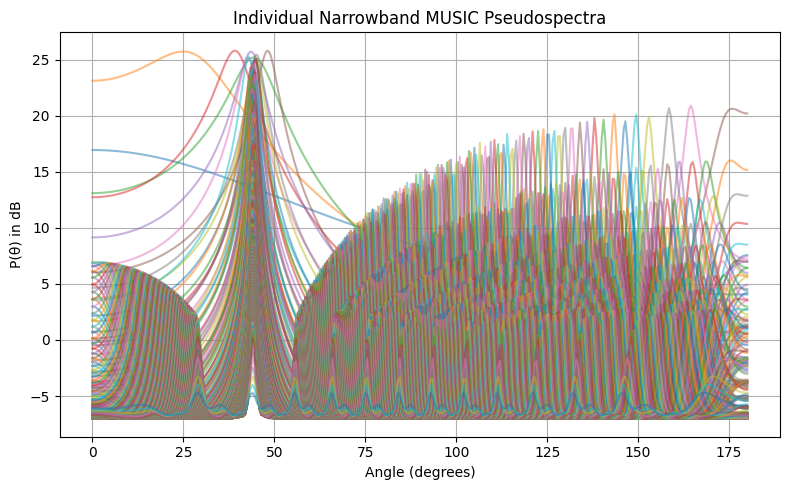

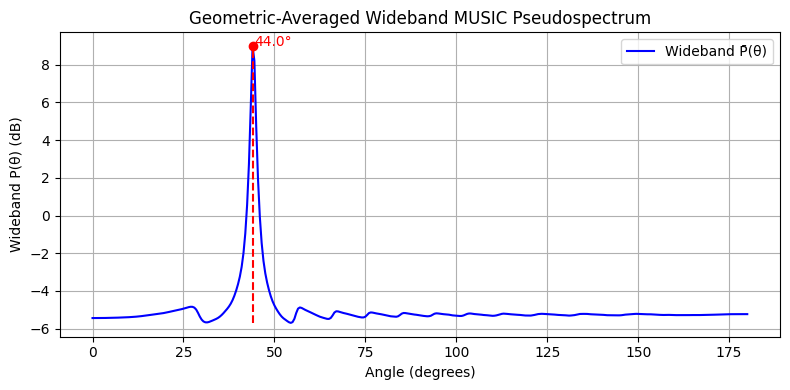

All estimated DOAs: [2521.01429858]
Selected estimated DOAs: [2521.01]
Ground truth DOAs: [43.61]
Estimate error(s): [0.39] deg.
[44.]


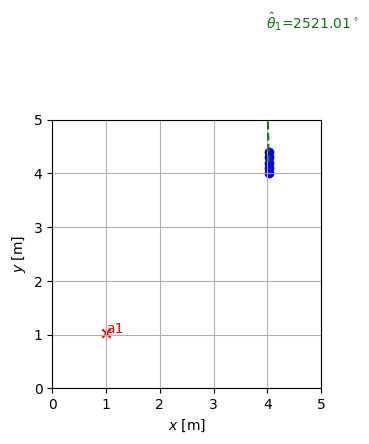

In [36]:
import numpy as np

winLength = 1024 # Window length
# nSources = acousticScenario.RIRsAudio.shape[-1] +\
#     acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')

# DOAestAll = DOA_corr("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)
# DOAestAll = music_narrowband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
DOAestAll = music_wideband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
# DOAestAll = np.zeros(nSources)  # default

print(f'All estimated DOAs: {DOAestAll * 180 / np.pi}')

# ------------------ DOA estimation performance check ------------------
# Automatic selection of the target DOA
DOAest, groundTruthDOAtalkers = genfcns.auto_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Selected estimated DOAs: {np.round(DOAest * 180 / np.pi, 2)}')
print(f'Ground truth DOAs: {np.round(groundTruthDOAtalkers * 180 / np.pi, 2)}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
# print(f'Estimate error(s): {np.round((DOAest - groundTruthDOAtalkers) * 180/np.pi, 2)} deg.')
print(f'Estimate error(s): {DOAestAll - np.round(groundTruthDOAtalkers * 180 / np.pi, 2)} deg.')
print(DOAestAll)

In [5]:
#frequency check
if acousticScenario.fs == 44100:
    print("Correct sampling frequency: 44.1 kHz")
else:
    raise ValueError(f"False: Incorrect sampling frequency, current sampling frequency {acousticScenario.fs} Hz")

Correct sampling frequency: 44.1 kHz


In [6]:
import numpy as np
from scipy.signal import stft

# parameters
fs = 44100            # sampling frequency
L = 1024              # window length
overlap = L // 2      # 50% overlap
mic_t = mic.T

f, t, stft_mics = stft(
    mic_t,
    fs=fs,
    window='hann',
    nperseg=L,
    noverlap=overlap,
    return_onesided=True,
    axis=1
)

print("STFT shape:", stft_mics.shape)


STFT shape: (5, 513, 863)


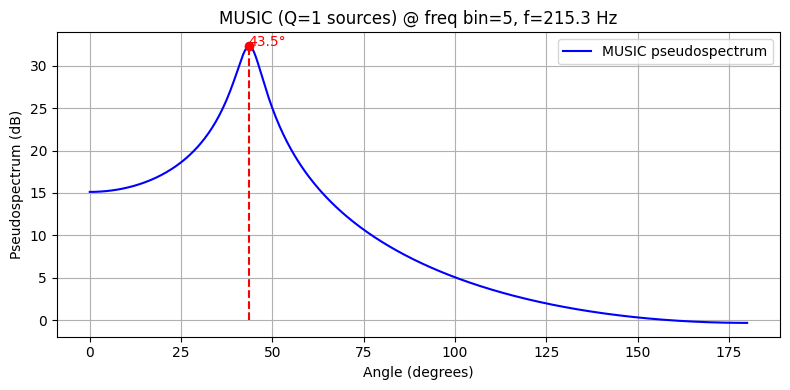

In [7]:
# narrowband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_narrowband(f, stft_mics, Q, d, c):   
    M, _, nT = stft_mics.shape
    
    power_per_bin = np.mean(np.abs(stft_mics)**2, axis=(0, 2))  # shape: (nF,)
    # power_per_bin[0] = 0  # Avoid DC bin
    fidx = np.argmax(power_per_bin) 
    f_bin = f[fidx]
    
    X_omega = stft_mics[:, fidx, :]  # shape: (M, nT)
    Rxx = (X_omega @ X_omega.conj().T) / nT  # (M, M)
    
    eigenvals, eigenvecs = np.linalg.eig(Rxx)
    sort_idx = np.argsort(eigenvals)       
    # eigenvals_sorted = eigenvals[sort_idx]
    eigenvecs_sorted = eigenvecs[:, sort_idx]
    Un = eigenvecs_sorted[:, :M - Q]  # shape (M, M-Q)  

    theta_vals = np.arange(0, 180.5, 0.5)
    theta_rad = np.deg2rad(theta_vals)[None,:]
    k0 = 2 * np.pi * f_bin / c  # wave number
    P_music = []
    
    m_index = np.arange(M)[:, None]

    S = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))
    v = Un.conj().T @ S
    norm_v_sq = np.sum(np.abs(v)**2, axis=0)
    P_music = 1 / norm_v_sq
    
    peaks, _ = find_peaks(P_music, distance=5, prominence=0.1)
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_values_all = P_music[peaks]
        if len(peaks) < Q:
            topQ_idx = np.argsort(peak_values_all)[::-1]  
        else:
            topQ_idx = np.argsort(peak_values_all)[-Q:]  

        topQ_idx_sorted = topQ_idx[np.argsort(peak_values_all[topQ_idx])]  
        
        peak_indices = peaks[topQ_idx_sorted]
        doa_estimates = theta_vals[peak_indices]
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(P_music), 'b-', label='MUSIC pseudospectrum')
    
    for idx in peak_indices:
        peak_angle = theta_vals[idx]
        peak_value = 10*np.log10(P_music[idx])
        plt.stem([peak_angle], [peak_value], linefmt='r--', markerfmt='ro', basefmt=" ")
        plt.text(peak_angle, peak_value, f"{peak_angle:.1f}°", color='red')
    
    plt.title(f"MUSIC (Q={Q} sources) @ freq bin={fidx}, f={f_bin:.1f} Hz")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Pseudospectrum (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

doa_estimates = music_narrowband(f, stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
# doa_estimates = music_narrowband(stft_mics, 1, 0.013, 340)


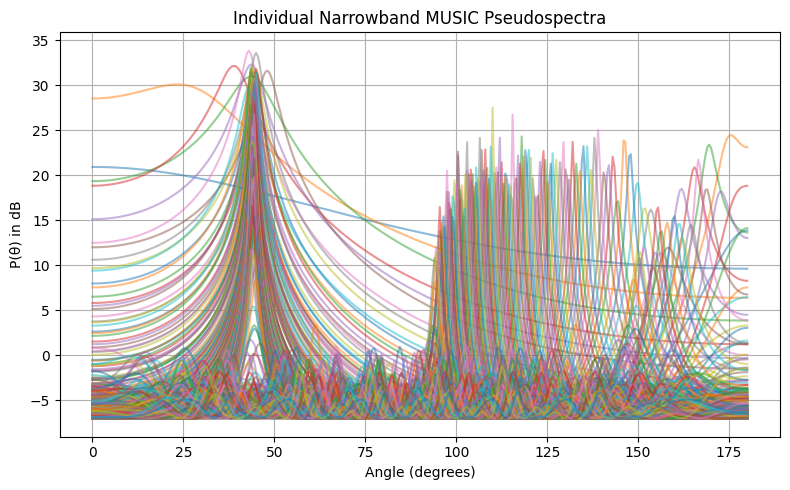

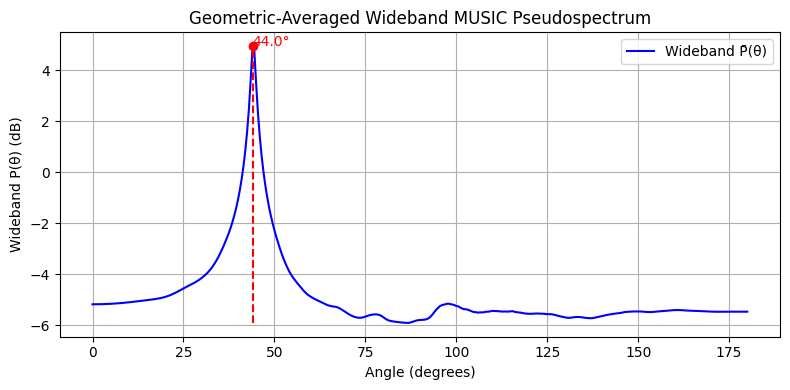

[44.]


In [8]:
# wideband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_wideband(f, stft_mics, Q, d, c):
    M, nF, nT = stft_mics.shape
    
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    freq_bins = range(1, nF-1)  
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)

    theta_rad = np.deg2rad(theta_vals)            # (nTheta,)
    theta_rad = theta_rad[np.newaxis, :]          # (1, nTheta)
    m_index = np.arange(M)[:, np.newaxis]         # (M, 1)
    
    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]
        
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT
        
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
        
        k0 = 2 * np.pi * f_bin / c

        S = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))
        v = Un.conj().T @ S

        norm_v_sq = np.sum(np.abs(v)**2, axis=0)  # shape (nTheta,)
        pseudospec = 1.0 / norm_v_sq              # shape (nTheta,)

        all_pseudospec[i, :] = pseudospec.real
    
    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    # plt.legend(loc='best', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    
    log_all = np.log(all_pseudospec)  
    mean_log = np.mean(log_all, axis=0)      
    p_wideband = np.exp(mean_log)   # shape: (nTheta,)

    if Q==1:
        peaks = np.argmax(p_wideband)
        peaks = np.array([peaks])
    else:
        peaks, properties = find_peaks(
            p_wideband,
            distance=4,    
            prominence=0.05,  
            height=0.5 * np.max(p_wideband)  # 过滤掉小于 60% 最大值的峰
        )
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)  
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]  
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    for doa in doa_estimates:
        val_db = 10*np.log10(p_wideband[theta_vals==doa])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
        plt.text(doa, val_db, f"{doa:.1f}°", color='red')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

c = 340

doa_estimates_wideband = music_wideband(f, stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)
# doa_estimates_wideband = music_wideband(stft_mics, 1, 0.215, c)
print(doa_estimates_wideband)

# closest_index = np.argmin(np.abs(doa_estimates_wideband - 90))

# # 获取最接近 90 的元素
# closest_value = doa_estimates_wideband[closest_index]

# print("最接近 90 的元素:", closest_value)

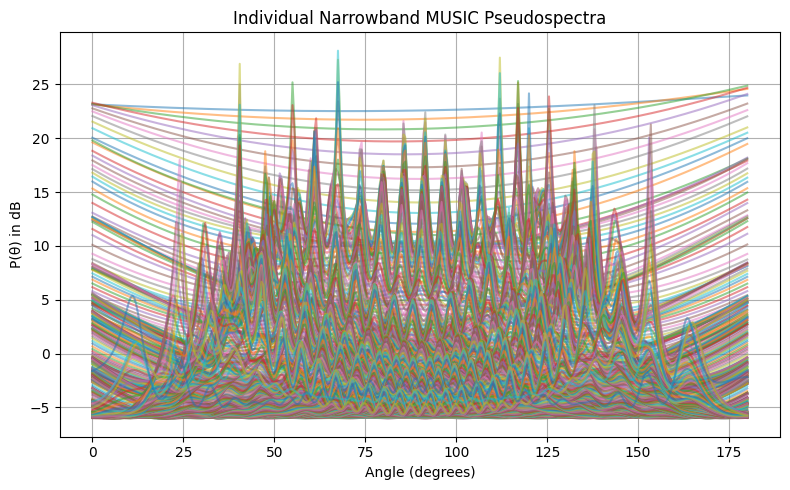

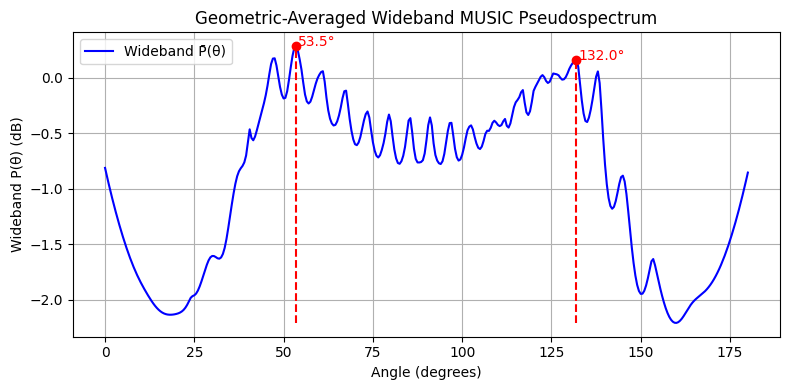

(4, 2)
[132.   53.5]


In [6]:
# Head-mounted(for loop unoptimized) 
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import find_peaks

# def music_wideband_HM(f, stft_mics, Q, c, mic_positions):

#     def steering_vector_2d(mic_positions, theta_deg, freq, c):
#         theta = np.deg2rad(theta_deg)
    
#         k0 = 2 * np.pi * freq / c
    
#         phase = k0 * (mic_positions[:, 0] * np.cos(theta)
#                     + mic_positions[:, 1] * np.sin(theta))        # shape: (M,)
    
#         a = np.exp(-1j * phase)
#         return a


#     M, nF, nT = stft_mics.shape
    
#     theta_vals = np.arange(0, 180.5, 0.5)
#     nTheta = len(theta_vals)
    
#     freq_bins = range(1, nF-1)  
#     nFreqUsed = len(freq_bins)
    
#     all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)
    
#     for i, fidx in enumerate(freq_bins):
#         f_bin = f[fidx]
        
#         X_omega = stft_mics[:, fidx, :]  # (M, nT)
#         Rxx = (X_omega @ X_omega.conj().T) / nT
        
#         eigenvals, eigenvecs = np.linalg.eig(Rxx)
#         sort_idx = np.argsort(eigenvals)
#         Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
  
#         for j, theta_deg in enumerate(theta_vals):
#             steer = steering_vector_2d(mic_positions, theta_deg, f_bin, c)
            
#             v = Un.conj().T @ steer
#             pseudospec = 1 / np.abs(v @ v.conj())
            
#             all_pseudospec[i, j] = pseudospec
    
#     plt.figure(figsize=(8,5))
#     for i in range(nFreqUsed):
#         plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
#     plt.title("Individual Narrowband MUSIC Pseudospectra")
#     plt.xlabel("Angle (degrees)")
#     plt.ylabel("P(θ) in dB")
#     plt.grid(True)
#     # plt.legend(loc='best', ncol=2, fontsize='small')
#     plt.tight_layout()
#     plt.show()
    
#     log_all = np.log(all_pseudospec)  
#     mean_log = np.mean(log_all, axis=0)      
#     p_wideband = np.exp(mean_log)   # shape: (nTheta,)            
    
#     peaks, properties = find_peaks(
#         p_wideband,
#         distance=20,     # 至少分开几个采样点(约2.5°=5*0.5°)
#         prominence=0.07  # 视数据情况调整
#         # height=0.6*np.max(p_wideband) 
#     )

#     # if p_wideband[0] > 0.9*np.max(p_wideband):
#     #     peaks = np.append(peaks, 0)
#     # if p_wideband[-1] > 0.8*np.max(p_wideband):
#     #     peaks = np.append(peaks, -1)
    
#     if len(peaks) == 0:
#         print("Warning: no peak found!")
#         doa_estimates = np.array([])
#     else:
#         peak_vals = p_wideband[peaks]
#         if len(peaks) >= Q:
#             idx_top = np.argsort(peak_vals)[-Q:]
#         else:
#             idx_top = np.argsort(peak_vals)  
#         idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
#         peak_indices = peaks[idx_top_sorted]
#         doa_estimates = theta_vals[peak_indices]  
    
#     plt.figure(figsize=(8,4))
#     plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
#     plt.grid(True)
#     plt.xlabel("Angle (degrees)")
#     plt.ylabel("Wideband P(θ) (dB)")
#     plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
#     for doa in doa_estimates:
#         val_db = 10*np.log10(p_wideband[theta_vals==doa])
#         plt.plot(doa, val_db, 'ro')
#         plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
#         plt.text(doa+0.5, val_db, f"{doa:.1f}°", color='red')
    
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    
#     return doa_estimates

# mic_positions = np.array([
#     [0, 0   ],  # L1
#     [0, -0.013],  # L2
#     [0.215, 0],   # R1
#     [0.215, -0.013]  # R2
#     # [0, 0.4]
# ])
# c = 340

# doa_estimates_wideband = music_wideband_HM(f, stft_mics, 2, c, mic_positions)

# print(mic_positions.shape)
# print(doa_estimates_wideband)



In [68]:
# Head-mounted
def music_wideband_HM(f, stft_mics, Q, c, mic_positions):
    M, nF, nT = stft_mics.shape

    theta_vals = np.arange(0, 180.5, 0.5) 
    nTheta = len(theta_vals)

    freq_bins = range(1, nF - 1)
    nFreqUsed = len(freq_bins)

    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)

    theta_rad = np.deg2rad(theta_vals)       # shape (nTheta,)
    cos_theta = np.cos(theta_rad)[np.newaxis, :]  # (1, nTheta)
    sin_theta = np.sin(theta_rad)[np.newaxis, :]  # (1, nTheta)

    x_mic = mic_positions[:, 0][:, np.newaxis]   # (M,1)
    y_mic = mic_positions[:, 1][:, np.newaxis]   # (M,1)

    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]

        X_omega = stft_mics[:, fidx, :]
        Rxx = (X_omega @ X_omega.conj().T) / nT

        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M - Q)]]  # (M, M-Q)

        k0 = 2 * np.pi * f_bin / c
        phase = k0 * (x_mic * cos_theta + y_mic * sin_theta)

        S = np.exp(-1j * phase)
        v = Un.conj().T @ S

        norm_v_sq = np.sum(np.abs(v)**2, axis=0)
        pseudospec = 1 / norm_v_sq

        all_pseudospec[i, :] = pseudospec.real  


    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]),
                 alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    log_all = np.log(all_pseudospec)         # shape: (nFreqUsed, nTheta)
    mean_log = np.mean(log_all, axis=0)     # shape: (nTheta,)
    p_wideband = np.exp(mean_log)           # (nTheta,)

    peaks, _ = find_peaks(
        p_wideband,
        distance=20,    # 20*0.5 = 10°
        prominence=0.07
        # height=0.6*np.max(p_wideband) 
    )

    # if p_wideband[0] > 0.9*np.max(p_wideband):
    #     peaks = np.append(peaks, 0)
    # if p_wideband[-1] > 0.8*np.max(p_wideband):
    #     peaks = np.append(peaks, -1)

    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]

    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")

    for doa in doa_estimates:
        idx = np.where(theta_vals == doa)[0][0]
        val_db = 10*np.log10(p_wideband[idx])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db,
                   color='r', linestyles='--')
        plt.text(doa + 0.5, val_db, f"{doa:.1f}°", color='red')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return doa_estimates

mic_positions = np.array([
    [0, 0   ],  # L1
    [0, -0.013],  # L2
    [0.215, 0],   # R1
    [0.215, -0.013]  # R2
    # [0, 0.4]
])
c = 340

doa_estimates_wideband = music_wideband_HM(f, stft_mics, 2, c, mic_positions)

print(mic_positions.shape)
print(doa_estimates_wideband)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 5)

(88201,)
44100


<Figure size 640x480 with 0 Axes>

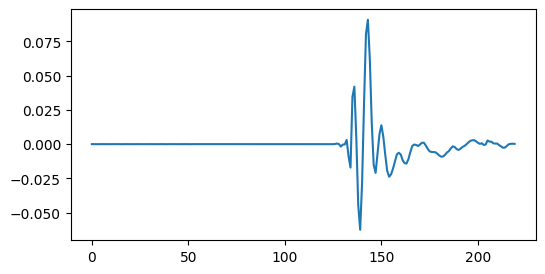

In [228]:
test1, fs_HMIR = sf.read("F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30\HMIR_L1.wav")
print(test1.shape)
print(fs_HMIR)
T_truncate = int(0.005*fs_HMIR)
sd.play(test1[0:T_truncate], samplerate=fs_HMIR)

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(test1[0:T_truncate])


# Week 3: DOA-informed Beamforming


this is done 1 times
this is done 2 times
this is done 3 times
this is done 4 times
this is done 5 times
SNR in Mic 1: 4.590397460333984 dB


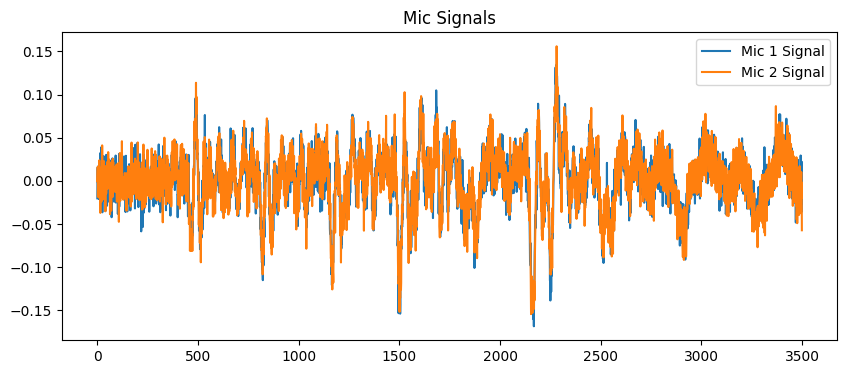

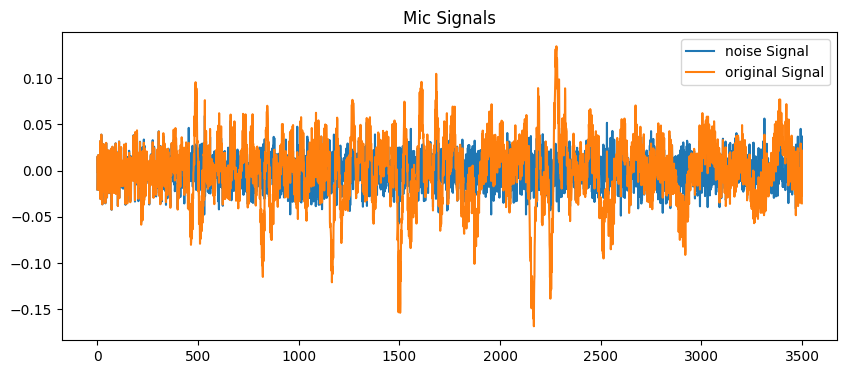

Shape of mic: (220500, 5)
Shape of speech: (220500, 5)
Shape of noise: (220500, 5)


In [100]:
# Part 1
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s, hmr_paths):
    # Check if fs is 44.1 kHz
    fs = acousticScenario.fs
    if fs != 44100:
        raise ValueError("Sampling frequency must be 44.1 kHz")

    if len(hmr_paths) == 0:
        
        num_micro = acousticScenario.RIRsAudio.shape[1]  # number of microphones
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        
        # Load and resample noise sources
        noise_components = []
        for file in noise_audio_files:
            noise, fs_noise = sf.read(file)
            
            noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
            noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
            noise_components.append(noise_padded)

        mic_signals = np.zeros((T_ds, num_micro))
        speech_3 = np.zeros((T_ds, 1))  # Placeholder for speech signal in the first mic
        noise_3 = np.zeros((T_ds, 1))  # Placeholder for noise in the first mic
        noise_sources_signal = np.zeros((T_ds, 1))  # Placeholder for noise sources in the first mic
        received_speech = np.zeros((T_ds, num_micro))
        
        received_noise = np.zeros((T_ds,num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
                #rir_speech /= np.max(np.abs(rir_speech))
                
                received_speech[:, mic_idx] += signal.fftconvolve(speech, rir_speech, mode='same')
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')

            for noise_idx, noise in enumerate(noise_components):
                rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
                #rir_noise /= np.max(np.abs(rir_noise))
                received_noise[:, mic_idx] += signal.fftconvolve(noise, rir_noise, mode='same') 
                mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')
                
                if mic_idx == 0:
                    noise_sources_signal[:, 0] += signal.fftconvolve(noise, rir_noise, mode='same')
            
            mic_signals[:, mic_idx] += mic_signal

            # Add noise to the first microphone signal
            if mic_idx == 0:
                vad = abs(received_speech[:,0]) > np.std(received_speech[:,0]) * 1e-3
                active_speech = received_speech[vad,0]
                P_speech = np.var(active_speech)
                P_noise_sources = np.var(noise_sources_signal[:, 0])
                noise_power = 0.1 * P_speech    # noise power
                
                # Add noise to the microphone signal
                i = 0
                for mic_idxx in range(num_micro):
                    i += 1
                    print("this is done", i, "times")
                    noise_signal = np.random.normal(0, np.sqrt(noise_power), len(speech_components[0]))
                    if (mic_idxx == 0):
                        noise_3[:, 0] = noise_signal  # Store additional noise signal    
                    mic_signals[:, mic_idxx] += noise_signal
                    received_noise[:, mic_idxx] += noise_signal
                    

        # Compute SNR for the first microphone
        P_noise_total = np.var(noise_3[:, 0]) + P_noise_sources
        SNR = 10 * np.log10(P_speech / P_noise_total)
        print(f"SNR in Mic 1: {SNR} dB")

    else:
        all_paths = []
        for fpath in hmr_paths:
            all_paths.append([fpath + "/HMIR_L1.wav", fpath + "/HMIR_L2.wav", fpath + "/HMIR_R1.wav", fpath + "/HMIR_R2.wav"])
        fs = sf.read(all_paths[0][0])[1]
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        noise_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            fs = fs_audio
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)

        num_micro = 4
        mic_signals = np.zeros((T_ds, num_micro))
        received_speech = np.zeros((T_ds, num_micro))
        received_noise = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = sf.read(all_paths[audio_idx][mic_idx])[0]
                rir_speech = rir_speech[0:int(0.005*fs)]    # truncate to prevent reverberation
                #rir_speech /= np.max(np.abs(rir_speech))
                received_speech[:, mic_idx] += signal.fftconvolve(speech, rir_speech, mode='same')
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')

            mic_signals[:, mic_idx] = mic_signal

    return mic_signals, received_speech, received_noise, fs


# Example usage
Time_duration = 5
mic, speech, noise, _ = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech1.wav"], ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\White_noise1.wav"], acousticScenario, Time_duration, [])    # "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav" ; "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s-30"
comb = speech[5500:9000, 0] + noise[5500:9000, 0]
plt.figure(figsize=(10, 4))
plt.plot(mic[5500:9000, 0], label="Mic 1 Signal")
plt.plot(mic[5500:9000, 1], label="Mic 2 Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(noise[5500:9000, 0], label="noise Signal")
plt.plot(comb, label="original Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()

# Print shape of the microphone signals
print('Shape of mic:', mic.shape)
print('Shape of speech:',speech.shape)
print('Shape of noise:',noise.shape)
sd.play(mic[:, 0], samplerate=acousticScenario.fs)
# sd.wait()  # Wait until playback finishes
# sd.play(speech[:, 0], samplerate=acousticScenario.fs)

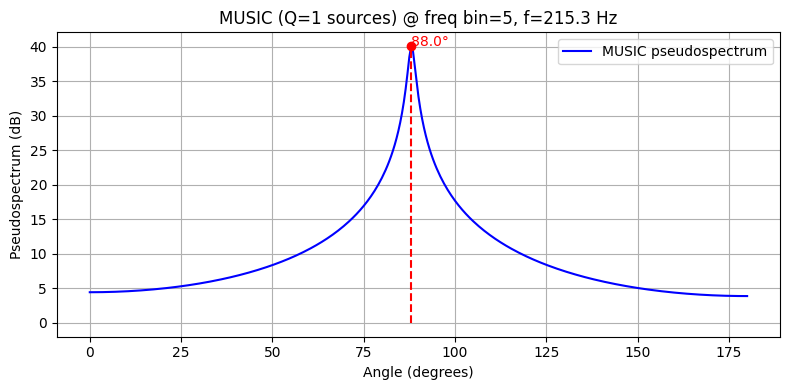

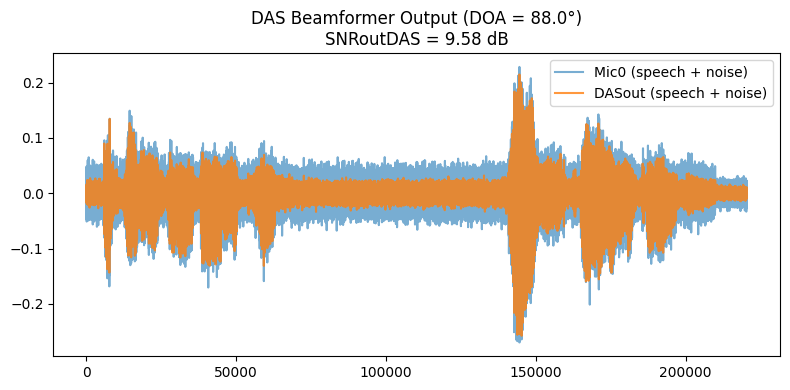

(220500,)
(220500,)
(220500,)
(220500, 5)


In [103]:
# beamforming
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def das_bf(mic, speech_component, noise_component, acousticScenario):
    c = 340                     # speed of sound
    fs = acousticScenario.fs    # sampling frequency
    L = 1024                    # window length
    overlap = L // 2                # 50% overlap
    mic_t = mic.T
    # if acousticScenario.RIRsNoise is not None:
    #     Q = acousticScenario.RIRsAudio.shape[-1] + acousticScenario.RIRsNoise.shape[-1] # Number of sources
    # else:
    #     Q = acousticScenario.RIRsAudio.shape[-1]

    f, _, stft_mics = stft(
        mic_t,
        fs=fs,
        window='hann',
        nperseg=L,
        noverlap=overlap,
        return_onesided=True,
        axis=1
    )

    DOA_est = music_narrowband(f, stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)

    target_index = np.argmin(np.abs(DOA_est - 90))
    target_angle = DOA_est[target_index]

    doa_deg = target_angle
    theta_rad = np.deg2rad(doa_deg)

    def delay_and_sum(signals, fs, dist, c, theta):
        N, M_ = signals.shape
        output = np.zeros(N)
        shifted_signals = np.zeros_like(signals)  # shape (N, M_)
        # delay = []
        
        for m in range(M_):
            mic_pos = m * dist
            delay_secs = (mic_pos * np.cos(theta)) / c
            delay_samples = -int(round(delay_secs * fs))
            # delay.append(-delay_samples)
            # print(f"mic {m} -> delay_samples = {delay_samples}, N={N}")

            shifted = np.zeros_like(signals[:, m])
            if delay_samples >= 0:
                if delay_samples >= N:
                    pass
                else:
                    shifted[delay_samples:] = signals[:(N-delay_samples), m]
            else:
                dly = -delay_samples
                if dly >= N:
                    pass
                else:
                    shifted[:N-dly] = signals[dly:, m]
            
            shifted_signals[:, m] = shifted
            output += shifted 
        return output, shifted_signals
    
    speechDAS, speechDAS_seperate = delay_and_sum(speech_component, fs, acousticScenario.distBwMics, c, theta_rad)
    noiseDAS, noiseDAS_seperate = delay_and_sum(noise_component, fs, acousticScenario.distBwMics, c, theta_rad)

    DASout = speechDAS + noiseDAS
    DASout_seperate = speechDAS_seperate + noiseDAS_seperate

    p_mic0_speech = np.var(speech[:, 0])
    p_das_speech  = np.var(speechDAS)
    # if p_das_speech > 1e-12:
    alpha = np.sqrt(p_mic0_speech / p_das_speech)
    # else:
    #     alpha = 1.0  
    
    speechDAS *= alpha
    noiseDAS  *= alpha
    DASout    *= alpha
    DASout_seperate *= alpha

    sig_power   = np.var(speechDAS)
    noise_power = np.var(noiseDAS) 
    SNRoutDAS   = 10 * np.log10(sig_power / noise_power)

    plt.figure(figsize=(8,4))
    # plt.plot(speech[:,0], label="Mic0 (speech only)", alpha=0.6)
    plt.plot(mic[:,0], label="Mic0 (speech + noise)", alpha=0.6)
    plt.plot(DASout, label="DASout (speech + noise)", alpha=0.8)
    plt.title(f"DAS Beamformer Output (DOA = {doa_deg:.1f}°)\nSNRoutDAS = {SNRoutDAS:.2f} dB")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate
        
DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate = das_bf(mic, speech, noise, acousticScenario)
print(DASout.shape)
print(speechDAS.shape)
print(noiseDAS.shape)
print(DASout_seperate.shape)

sd.play(DASout, samplerate=acousticScenario.fs)

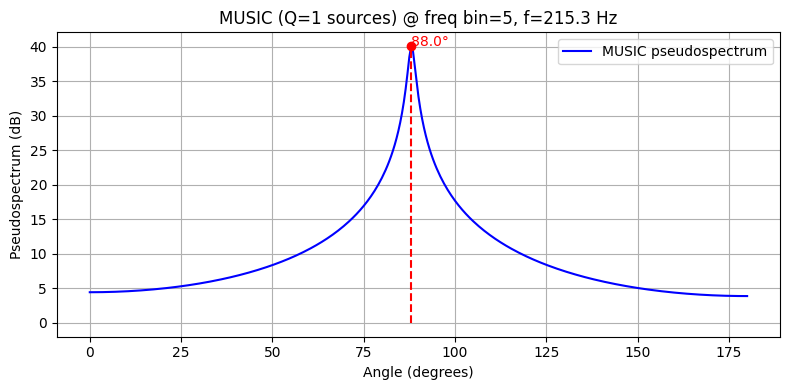

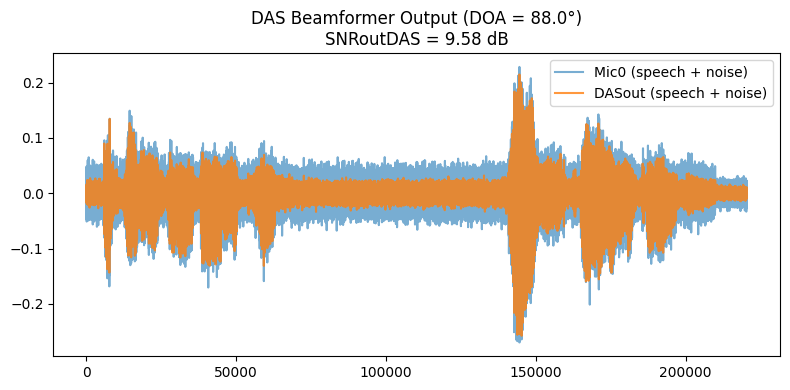

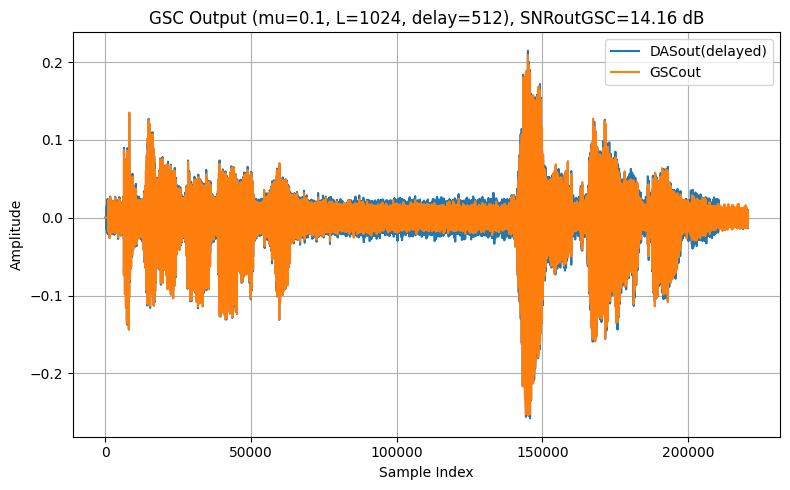

(220500, 1)


In [133]:
# GSC
import numpy as np
import matplotlib.pyplot as plt

def gsc_td(mic, speech_component, noise_component, acousticScenario, mu, L, Delta):

    DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_aligned = das_bf(mic, speech_component, noise_component,acousticScenario)
    N = len(DASout)
    
    M = mic.shape[1]
    B1 = -np.eye(M-1)
    B2 = np.ones((M-1,1))
    B = np.hstack((B2, B1)) # shape: (M-1, M)
    
    X_block = DASout_aligned @ B.T   # shape: (N, M-1)

    Das_delayed = np.zeros(N)
    # Das_delayed = np.roll(DASout, shift=-Delta)
    Das_delayed[Delta:] = DASout[:N - Delta]
    
    W = np.zeros((L, M-1))
    GSCout = np.zeros((N, 1))

    vad = abs(speechDAS) > np.std(speechDAS) * 1e-3
    
    for n in range(L, N):
        slice_block = X_block[n-L:n,:]
        len_slice = slice_block.shape[0]

        if len_slice < L:
            pad_length = L - len_slice 
            slice_block = np.pad(slice_block, ((0, pad_length), (0, 0)), mode='constant')

        noise_est_matrix = W.T @ slice_block
        noise_est = np.trace(noise_est_matrix)
        e_n = Das_delayed[n] - noise_est
        if vad[n] == 0:
            W += mu * e_n * slice_block / np.linalg.norm(slice_block, ord='fro')**2
        # W += mu * e_n * slice_block / np.sum(slice_block**2)
        GSCout[n] = e_n
    
    GSCout_active = GSCout[vad == 1,0]
    GSCout_noise = GSCout[vad == 0,0]
    GSCout_active_power = np.var(GSCout_active)
    GSCout_noise_power = np.var(GSCout_noise)
    SNRoutGSC = 10 * np.log10(GSCout_active_power / GSCout_noise_power)
    
    # gsc_en = np.mean(GSCout**2)
    # das_en = np.mean(Das_delayed**2)

    # if gsc_en > 1e-12:  # 防止除0
    #     alpha = np.sqrt(das_en / gsc_en)
    # else:
    #     alpha = 1.0

    # GSCout = alpha * GSCout

    plt.figure(figsize=(8,5))
    # plt.plot(mic[:,0], label='DASout')
    plt.plot(Das_delayed, label="DASout(delayed)")
    plt.plot(GSCout, label='GSCout')
    # plt.plot(speechDAS, label='DAS-speech-only', alpha=0.7)
    plt.title(f"GSC Output (mu={mu}, L={L}, delay={Delta}), SNRoutGSC={SNRoutGSC:.2f} dB")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return GSCout, SNRoutGSC, X_block


mu = 0.1
L = 1024
Delta = int(L/2)
GSCout, SNRoutGSC, X_block = gsc_td(mic, speech, noise, acousticScenario, mu, L, Delta)
print(GSCout.shape)


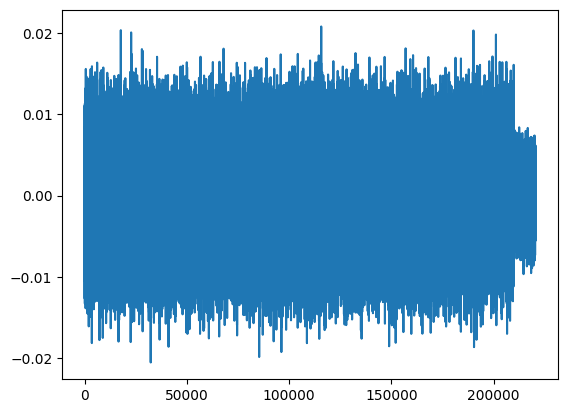

In [134]:
sd.play(GSCout, samplerate=acousticScenario.fs)
# sd.play(X_block[:,0], samplerate=acousticScenario.fs)
# vad = abs(speechDAS) > np.std(speechDAS) * 1e-3
# print(vad)
# plt.plot(vad)
plt.plot(X_block[:,0])

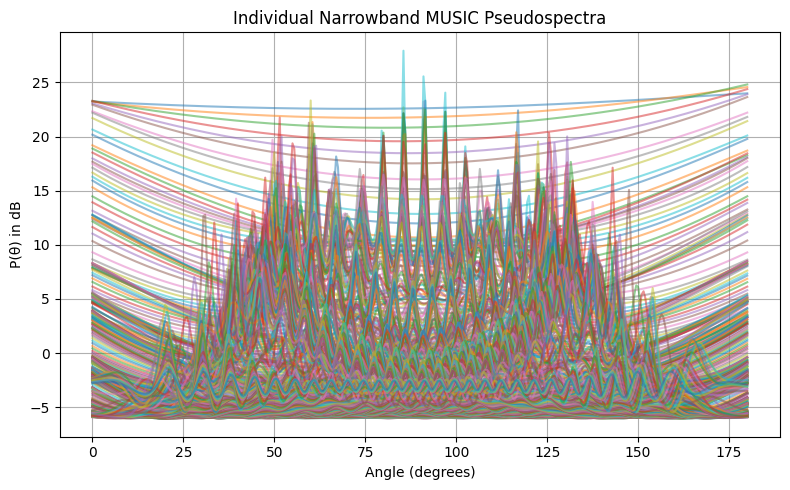

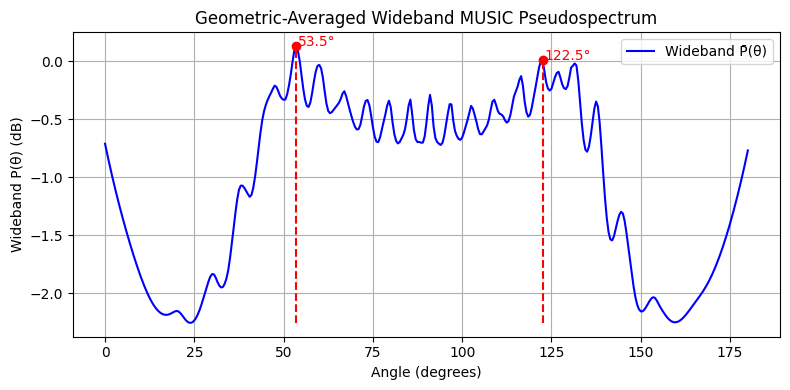

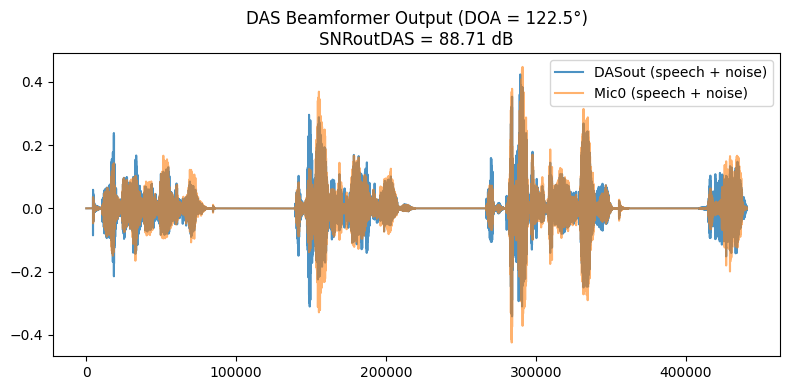

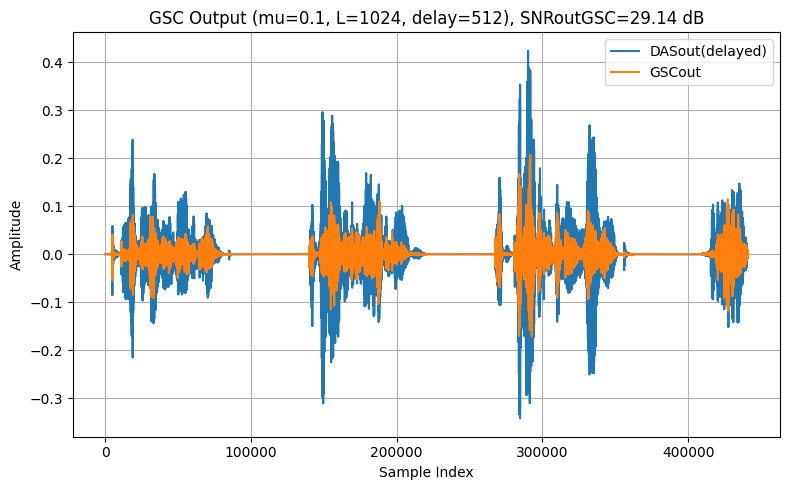

In [63]:
# Head-mounted case
import numpy as np
import matplotlib.pyplot as plt

def das_bf_HM(mic, speech_component, noise_component, mic_positions):
    c = 340                     # speed of sound
    fs = 44100    # sampling frequency
    L = 1024                    # window length
    overlap = L // 2                # 50% overlap

    mic_t = mic.T

    f, _, stft_mics = stft(
        mic_t,
        fs=fs,
        window='hann',
        nperseg=L,
        noverlap=overlap,
        return_onesided=True,
        axis=1
    )

    DOA_est = music_wideband_HM(f, stft_mics, 2, c, mic_positions)

    target_index = np.argmin(np.abs(DOA_est - 90))
    target_angle = DOA_est[target_index]

    doa_deg = target_angle
    theta_rad = np.deg2rad(doa_deg)

    def delay_and_sum(signals, fs, mic_positions, c, theta):
        N, M_ = signals.shape
        output = np.zeros(N)
        shifted_signals = np.zeros_like(signals)  # shape (N, M_)
        # delay = []
        
        for m in range(M_):
            x_m, y_m = mic_positions[m]
            # delay_secs = (x_m * np.cos(theta) + y_m * np.sin(theta)) / c
            delay_secs = (x_m * np.sin(theta) + y_m * np.cos(theta)) / c

            delay_samples = int(round(delay_secs * fs))
            # delay.append(-delay_samples)
            # print(f"mic {m} -> delay_samples = {delay_samples}, N={N}")

            shifted = np.zeros_like(signals[:, m])
            if delay_samples >= 0:
                if delay_samples >= N:
                    pass
                else:
                    shifted[delay_samples:] = signals[:(N-delay_samples), m]
            else:
                dly = -delay_samples
                if dly >= N:
                    pass
                else:
                    shifted[:N-dly] = signals[dly:, m]
            
            shifted_signals[:, m] = shifted
            output += shifted 
        return output, shifted_signals
    
    speechDAS, speechDAS_seperate = delay_and_sum(speech_component, fs, mic_positions, c, theta_rad)
    noiseDAS, noiseDAS_seperate = delay_and_sum(noise_component, fs, mic_positions, c, theta_rad)

    DASout = speechDAS + noiseDAS
    DASout_seperate = speechDAS_seperate + noiseDAS_seperate

    p_mic0_speech = np.var(speech[:, 0])
    p_das_speech  = np.var(speechDAS)
    alpha = np.sqrt(p_mic0_speech / p_das_speech)
    
    speechDAS *= alpha
    noiseDAS  *= alpha
    DASout    *= alpha
    DASout_seperate *= alpha

    sig_power   = np.var(speechDAS)
    noise_power = np.var(noiseDAS)
    if noise_power < 1e-12:
        noise_power = 1e-12
    SNRoutDAS   = 10 * np.log10(sig_power / noise_power)

    plt.figure(figsize=(8,4))
    # plt.plot(speech[:,0], label="Mic0 (speech only)", alpha=0.6)
    plt.plot(DASout, label="DASout (speech + noise)", alpha=0.8)
    plt.plot(mic[:,0], label="Mic0 (speech + noise)", alpha=0.6)
    plt.title(f"DAS Beamformer Output (DOA = {doa_deg:.1f}°)\nSNRoutDAS = {SNRoutDAS:.2f} dB")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate



def gsc_td_HM(mic, speech_component, noise_component, mic_positions, mu, L, Delta):
    DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_aligned = das_bf_HM(mic, speech_component, noise_component, mic_positions)
    N = len(DASout)
    
    M = mic.shape[1]
    B1 = -np.eye(M-1)
    B2 = np.ones((M-1,1))
    B = np.hstack((B2, B1)) # B.shape: (M-1, M)
    
    X_block = DASout_aligned @ B.T   # shape: (N, M-1)

    Das_delayed = np.zeros(N)
    Das_delayed[Delta:] = DASout[:N - Delta]
    
    W = np.zeros((L, M-1))
    GSCout = np.zeros((N, 1))

    vad = abs(speechDAS) > np.std(speechDAS) * 1e-3
    
    for n in range(L, N):
        slice_block = X_block[n-L:n,:]
        len_slice = slice_block.shape[0]

        if len_slice < L:
            pad_length = L - len_slice 
            slice_block = np.pad(slice_block, ((0, pad_length), (0, 0)), mode='constant')

        noise_est_matrix = W.T @ slice_block
        noise_est = np.trace(noise_est_matrix)
        e_n = Das_delayed[n] - noise_est
        W += mu * e_n * slice_block / np.linalg.norm(slice_block, ord='fro')**2
        GSCout[n] = e_n
    
    GSCout_active = GSCout[vad == 1,0]
    GSCout_noise = GSCout[vad == 0,0]
    GSCout_active_power = np.var(GSCout_active)
    GSCout_noise_power = np.var(GSCout_noise)
    SNRoutGSC = 10 * np.log10(GSCout_active_power / GSCout_noise_power)
    
    # gsc_en = np.var(GSCout)
    # das_en = np.var(Das_delayed)

    # if gsc_en > 1e-12:  # 防止除0
    #     alpha = np.sqrt(das_en / gsc_en)
    # else:
    #     alpha = 1.0

    # GSCout = alpha * GSCout

    plt.figure(figsize=(8,5))
    # plt.plot(mic[:,0], label='DASout')
    plt.plot(Das_delayed, label="DASout(delayed)")
    plt.plot(GSCout, label='GSCout')
    # plt.plot(speechDAS, label='DAS-speech-only', alpha=0.7)
    plt.title(f"GSC Output (mu={mu}, L={L}, delay={Delta}), SNRoutGSC={SNRoutGSC:.2f} dB")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return GSCout, SNRoutGSC, X_block


mu = 0.1
L = 1024
Delta = int(L/2)
mic_positions = np.array([
    [0, 0   ],  # L1
    [0, -0.013],  # L2
    [0.215, 0],   # R1
    [0.215, -0.013]  # R2
    # [0, 0.4]
])

# DASout, speechDAS, noiseDAS, SNRoutDAS, DASout_seperate = das_bf_HM(mic, speech, noise, mic_positions)
# print(DASout.shape)
# print(speechDAS.shape)
# print(noiseDAS.shape)
# print(DASout_seperate.shape)

# sd.play(DASout, samplerate=acousticScenario.fs)

GSCout, SNRoutGSC, X_block = gsc_td_HM(mic, speech, noise, mic_positions, mu, L, Delta)



In [62]:
sd.play(GSCout, samplerate=acousticScenario.fs)
# sd.play(X_block[:,0], samplerate=acousticScenario.fs)